## Overview

This demo shows how to use CVIs to measure how two online clustering processes can differ.
Here, we load a simple dataset and run two clustering algorithms to prescribe a set of clusters to the features.
We will also compute their respective criterion values in-the-loop.
Though this simple example demonstrates the usage of a single CVI, it may be substituted for any other CVI in the `ClusterValidityIndices.jl` package.

## Clustering

### Data Setup

First, we must load all of our dependencies.
We will load the `ClusterValidityIndices.jl` along with some data utilities and the Julia `Clustering.jl` package to cluster that data.

In [1]:
using ClusterValidityIndices    # CVI/ICVI
using AdaptiveResonance         # DDVFA
using MLDatasets                # Iris dataset
using DataFrames                # DataFrames, necessary for MLDatasets.Iris()
using MLDataUtils               # Shuffling and splitting
using Printf                    # Formatted number printing
using Plots                     # Plots frontend
gr()                            # Use the default GR backend explicitly
theme(:dracula)                 # Change the theme for fun

We will download the Iris dataset for its small size and benchmark use for clustering algorithms.

In [2]:
iris = Iris(as_df=false)
features, labels = iris.features, iris.targets

([5.1 4.9 … 6.2 5.9; 3.5 3.0 … 3.4 3.0; 1.4 1.4 … 5.4 5.1; 0.2 0.2 … 2.3 1.8], InlineStrings.String15["Iris-setosa" "Iris-setosa" … "Iris-virginica" "Iris-virginica"])

Because the MLDatasets package gives us Iris labels as strings, we will use the `MLDataUtils.convertlabel` method with the `MLLabelUtils.LabelEnc.Indices` type to get a list of integers representing each class:}

In [3]:
labels = convertlabel(LabelEnc.Indices{Int}, vec(labels))
unique(labels)

3-element Vector{Int64}:
 1
 2
 3

### ART Online Clustering

Adaptive Resonance Theory (ART) is a neurocognitive theory that is the basis of a class of online clustering algorithms.
Because these clustering algorithms run online, we can both cluster and compute a new criterion value at every step.
For more on these ART algorithms, see [`AdaptiveResonance.jl`](https://github.com/AP6YC/AdaptiveResonance.jl).

We will create two Distributed Dual-Vigilance Fuzzy ART (DDVFA) modules with two different options for comparison.

In [4]:
# Create a list of two DDVFA modules with different options
arts = [
    DDVFA()                         # Default options
    DDVFA(rho_lb=0.6, rho_ub=0.7)   # Specified options
]
typeof(arts)

Vector{DDVFA} (alias for Array{AdaptiveResonance.DDVFA, 1})

Because we are streaming clustering, we must setup the internal data setup of both of the modules.
This is akin to doing some data preprocessing and communicating the dimension of the data, bounds, etc. to the module beforehand.

In [5]:
# Setup the data configuration for both modules
for art in arts
    data_setup!(art, features)
end

We can now cluster and get the criterion values online.
We will do this by creating two CVI objects for both clustering modules, setting up containers for the iterations, and then iterating.

In [6]:
# Create two CVI objects, one for each clustering module
n_cvis = length(arts)
cvis = [CH() for _ = 1:n_cvis]

# Setup the online/streaming clustering
n_samples = length(labels)                  # Number of samples
c_labels = zeros(Int, n_samples, n_cvis)     # Clustering labels for both
criterion_values = zeros(n_samples, n_cvis)  # ICVI outputs

# Iterate over all samples
for ix = 1:n_samples
    # Extract one sample
    sample = features[:, ix]
    # Iterate over all clustering algorithms and CVIs
    for jx = 1:n_cvis
        # Cluster the sample online
        local_label = train!(arts[jx], sample)
        c_labels[ix, jx] = local_label
        # Get the new criterion value (ICVI output)
        criterion_values[ix, jx] = get_cvi!(cvis[jx], sample, local_label)
    end
end

# See the list of criterion values
criterion_values

150×2 Matrix{Float64}:
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   0.0      0.0
   ⋮      
 175.702  354.422
 176.989  356.081
 177.77   362.412
 178.503  366.857
 180.181  367.729
 181.891  369.9
 183.969  369.496
 185.974  368.577
 187.456  371.06

Because we ran it iteratively, we can also see how the criterion value evolved over time in a plot!

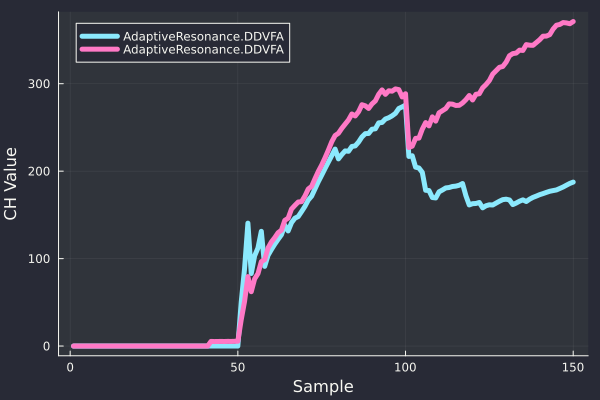

In [7]:
# Create the plotting function
function plot_icvis(criterion_values)
    p = plot(legend=:topleft)
    for ix = 1:n_cvis
        plot!(
            p,
            1:n_samples,
            criterion_values[:, ix],
            linewidth = 5,
            label = string(typeof(arts[ix])),
            xlabel = "Sample",
            ylabel = "$(typeof(cvis[ix])) Value",
        )
    end
    return p
end

# Show the plot
p = plot_icvis(criterion_values)

We can clearly see that the CVIs illustrate a difference in how the two clustering algorithms operate.
By changing the options of the clustering algorithms just a little bit, they cluster vastly differently, which is reflected in the difference in the ICVIs that broadens each time step.

In [8]:
png("assets/clustering-comparison") #hide

"assets/clustering-comparison.png"

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*